# Information Retrieval 1#
## Assignment 2: Retrieval models [100 points] ##

In this assignment you will get familiar with basic and advanced information retrieval concepts. You will implement different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Wednesday, January 31st**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](piazza.com/university_of_amsterdam/spring2018/52041inr6y/home).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [1]:
import logging
import sys
import os

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example
Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example


Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.

    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [2]:
import sys

sys.path.append('/usr/local/lib/python3.5/dist-packages')

import pyndri

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [3]:
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

In [4]:
example_document = index.document(index.document_base())
print(example_document)

('AP890425-0001', (1360, 192, 363, 0, 880, 0, 200, 0, 894, 412, 92160, 3, 192, 0, 363, 34, 1441, 0, 174134, 0, 200, 0, 894, 412, 2652, 0, 810, 107, 49, 4903, 420, 0, 1, 48, 35, 489, 0, 35, 687, 192, 243, 0, 249311, 1877, 0, 1651, 1174, 0, 2701, 117, 412, 0, 810, 391, 245233, 1225, 5838, 16, 0, 233156, 3496, 0, 393, 17, 0, 2435, 4819, 930, 0, 0, 200, 0, 894, 0, 22, 398, 145, 0, 3, 271, 115, 0, 1176, 2777, 292, 0, 725, 192, 0, 0, 50046, 0, 1901, 1130, 0, 192, 0, 408, 0, 243779, 0, 0, 553, 192, 0, 363, 0, 3747, 0, 0, 0, 0, 1176, 0, 1239, 0, 0, 1115, 17, 0, 0, 585, 192, 1963, 0, 0, 412, 54356, 0, 773, 0, 0, 0, 192, 0, 0, 1130, 0, 363, 0, 545, 192, 0, 1174, 1901, 1130, 0, 4, 398, 145, 39, 0, 577, 0, 355, 0, 491, 0, 6025, 0, 0, 193156, 88, 34, 437, 0, 0, 1852, 0, 828, 0, 1588, 0, 0, 0, 2615, 0, 0, 107, 49, 420, 0, 0, 190, 7, 714, 2701, 0, 237, 192, 157, 0, 412, 34, 437, 0, 0, 200, 6025, 26, 0, 0, 0, 0, 363, 0, 22, 398, 145, 0, 200, 638, 126222, 6018, 0, 880, 0, 0, 161, 0, 0, 319, 894, 2701, 

Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens we take a look at the dictionary of the index:

In [5]:
token2id, id2token, _ = index.get_dictionary()
print(list(id2token.items())[:15])

[(1, 'new'), (2, 'percent'), (3, 'two'), (4, '1'), (5, 'people'), (6, 'million'), (7, '000'), (8, 'government'), (9, 'president'), (10, 'years'), (11, 'state'), (12, '2'), (13, 'states'), (14, 'three'), (15, 'time')]


Using this dictionary we can see the tokens for the (non-stop) words in our example document:

In [6]:
print([id2token[word_id] for word_id in example_document[1] if word_id > 0])

['52', 'students', 'arrested', 'takeover', 'university', 'massachusetts', 'building', 'fifty', 'two', 'students', 'arrested', 'tuesday', 'evening', 'occupying', 'university', 'massachusetts', 'building', 'overnight', 'protest', 'defense', 'department', 'funded', 'research', 'new', 'york', 'city', 'thousands', 'city', 'college', 'students', 'got', 'unscheduled', 'holiday', 'demonstrators', 'occupied', 'campus', 'administration', 'building', 'protest', 'possible', 'tuition', 'increases', 'prompting', 'officials', 'suspend', 'classes', '60', 'police', 'riot', 'gear', 'arrived', 'university', 'massachusetts', '5', 'p', 'm', 'two', 'hours', 'later', 'bus', 'drove', 'away', '29', 'students', 'camped', 'memorial', 'hall', 'students', 'charged', 'trespassing', '23', 'students', 'arrested', 'lying', 'bus', 'prevent', 'leaving', 'police', '300', 'students', 'stood', 'building', 'chanting', 'looking', 'students', 'hall', 'arrested', '35', 'students', 'occupied', 'memorial', 'hall', '1', 'p', 'm',

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

In [7]:
query_tokens = index.tokenize("University of Massachusetts")
print("Query by tokens:", query_tokens)
query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
print("Query by ids with stopwords:", query_id_tokens)
query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
print("Query by ids without stopwords:", query_id_tokens)

Query by tokens: ['university', '', 'massachusetts']
Query by ids with stopwords: [200, 0, 894]
Query by ids without stopwords: [200, 894]


Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

In [8]:
matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
print("Document %s has %d word matches with query: \"%s\"." % (example_document[0], matching_words, ' '.join(query_tokens)))
print("Document %s and query \"%s\" have a %.01f%% overlap." % (example_document[0], ' '.join(query_tokens),matching_words/float(len(example_document[1]))*100))

Document AP890425-0001 has 13 word matches with query: "university  massachusetts".
Document AP890425-0001 and query "university  massachusetts" have a 2.5% overlap.


While this is certainly not everything Pyndri can do, it should give you an idea of how to use it. Please take a look at the [examples](https://github.com/cvangysel/pyndri) as it will help you a lot with this assignment.

**CAUTION**: Avoid printing out the whole index in this Notebook as it will generate a lot of output and is likely to corrupt the Notebook.

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [9]:
import collections
import io
import logging
import sys

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

with open('./ap_88_89/topics_title', 'r') as f_topics:
    print(parse_topics([f_topics]))

OrderedDict([('51', 'Airbus Subsidies'), ('52', 'South African Sanctions'), ('53', 'Leveraged Buyouts'), ('54', 'Satellite Launch Contracts'), ('55', 'Insider Trading'), ('56', 'Prime (Lending) Rate Moves, Predictions'), ('57', 'MCI'), ('58', 'Rail Strikes'), ('59', 'Weather Related Fatalities'), ('60', 'Merit-Pay vs. Seniority'), ('61', 'Israeli Role in Iran-Contra Affair'), ('62', "Military Coups D'etat"), ('63', 'Machine Translation'), ('64', 'Hostage-Taking'), ('65', 'Information Retrieval Systems'), ('66', 'Natural Language Processing'), ('67', 'Politically Motivated Civil Disturbances'), ('68', 'Health Hazards from Fine-Diameter Fibers'), ('69', 'Attempts to Revive the SALT II Treaty'), ('70', 'Surrogate Motherhood'), ('71', 'Border Incursions'), ('72', 'Demographic Shifts in the U.S.'), ('73', 'Demographic Shifts across National Boundaries'), ('74', 'Conflicting Policy'), ('75', 'Automation'), ('76', 'U.S. Constitution - Original Intent'), ('77', 'Poaching'), ('78', 'Greenpeace'

### Task 1: Implement and compare lexical IR methods [35 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html) and 
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[5 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand who the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [10]:
import time

with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')

num_documents = index.maximum_document() - index.document_base()

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation.
start_time = time.time()

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

total_terms = 0

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

avg_doc_length = total_terms / num_documents

print('Inverted index creation took', time.time() - start_time, 'seconds.')

Gathering statistics about 456 terms.
Inverted index creation took 36.36901903152466 seconds.


In [11]:
def run_retrieval(model_name, score_fn, fpath_qrel = './ap_88_89/qrel_test', print_info = False):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    run_out_path = '{}.run'.format(model_name)

    if os.path.exists(run_out_path):
        print("warning: the file {0} already exists and is not overwritten.".format(run_out_path))
        return

    retrieval_start_time = time.time()

    if print_info:
        print('Retrieving using', model_name)
    
    data = build_data(fpath_qrel, score_fn)


    # TODO: fill the data dictionary. 
    # The dictionary data should have the form: query_id --> (document_score, external_doc_id)
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)

In [12]:
# Helper functions for reading data

def parse_query_relevance_file(fpath):
    with open(fpath, 'r') as rels:
        doc_ids = []
        query_id = None
        for rel_line in rels:
            q_d_rel = rel_line.split()
            q_id = q_d_rel[0]
            doc_id = q_d_rel[2]
            if not query_id:
                query_id = q_id
                doc_ids.append(doc_id)
            elif query_id == q_id:
                doc_ids.append(doc_id)
            else:
                query_docs = (query_id, get_query_term_ids(query_id), doc_ids, get_int_document_ids(doc_ids))
                query_id = q_id
                doc_ids = []
                yield query_docs

def get_query_term_ids(query_id):
    query_text = queries[query_id]
    query_terms = index.tokenize(query_text)
    query_term_ids = [token2id.get(query_term,0) for query_term in query_terms if token2id.get(query_term,0) > 0]
    return query_term_ids

def get_int_document_ids(document_ids):
    int_document_ids = [doc_index for _, doc_index in index.document_ids(document_ids)]
    return int_document_ids

def build_data(fpath, score_fn, top = 1000):                
    data = {}
    for (q_id, q_term_ids, doc_ids, int_doc_ids) in parse_query_relevance_file(fpath):
        top_doc_ids = doc_ids[:top] if top else doc_ids
        top_int_doc_ids = get_int_document_ids(top_doc_ids)
        zipped_doc_ids = zip(top_doc_ids, top_int_doc_ids)
        data[q_id] = tuple((score_fn(int_doc_id, q_term_ids), doc_id) for (doc_id, int_doc_id) in zipped_doc_ids)
    return data

$tf\_idf(t;d) = \log (1 + tf(t;d))[log(n) - log(df(t))] $
with $tf(t;d)$ the number of times term $t$ occurs in document $d$,
$n$ the total number of documents,
$df(t)$ the number of documents in which term $t$ occurs.

Score of query is sum of $tf\_idf$ weights of terms in the query.

In [13]:
import math
import numpy as np

def tfidf(int_document_id, query_term_ids, document_term_freq = None):
    """
    TFIDF scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """

    # TODO: add comment(s)
    def _tfidf(int_document_id, query_term_id):
        document_term_freq = inverted_index[query_term_id].get(int_document_id, 0)
        num_documents = index.maximum_document() - index.document_base()
        num_documents_with_term = len(inverted_index[query_term_id])
        tf = math.log(1 + document_term_freq)
        idf = math.log(num_documents) - math.log(num_documents_with_term)
        score = tf * idf
        return score

    return sum([_tfidf(int_document_id, qt_id) for qt_id in query_term_ids])

In [14]:
# We need this for BM25, calculating each time is too expensive
# TODO: better solution than making it a global?
# ALREADY DEFINED EARLIER
#avg_doc_length = np.mean([len(index.document(i)) 
#                                   for i in range(index.document_base(), index.maximum_document())])

def BM25(int_document_id, query_term_ids, k1 = 1.5, b = 0.75):
    """
    BM25 scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param lambda (𝛌): smoothing parameter in the range [0.1, 0.5, 0.9]
    """
    
    document_length = len(index.document(int_document_id)[1])
    doc_length_normalization_term = ((1 - b) + b * (document_length / avg_doc_length))
    
    def _BM25(int_document_id, query_term_id):
        
        # idf
        num_documents_with_term = len(inverted_index[query_term_id])
        idf = math.log(num_documents) - math.log(num_documents_with_term)
        
        # tf adjusted for document length and saturation
        document_term_freq = inverted_index[query_term_id].get(int_document_id, 0)
        adjusted_term_freq = ((k1 + 1) * document_term_freq) / (k1 * doc_length_normalization_term + document_term_freq)

        # score
        return adjusted_term_freq * idf

    unique_query_term_ids = set(query_term_ids)
    return sum([_BM25(int_document_id, qt_id) for qt_id in unique_query_term_ids])

In [15]:
# We need this for jelinek_mercer, dirichlet_prior, absolute_discounting
# TODO: better solution than making it a global?
corpus_size = sum([len(index.document(i)[1]) for i in range(index.document_base(), index.maximum_document())])
corpus_size

75983583

In [16]:
# Make corpus term frequency for language models with query terms only
corpus_term_freqs = collections.defaultdict(lambda: 0, key = 0)

for query_key in inverted_index.keys():
    for document_key in inverted_index[query_key].keys():
        corpus_term_freqs[query_key] += inverted_index[query_key][document_key]

In [17]:
# Make total corpus term frequency for language models
total_corpus_term_freqs = collections.defaultdict(lambda: 0, key = 0)

for document_index in range(index.document_base(), index.maximum_document()):
    document = index.document(document_index)[1]
    for term in document:
        total_corpus_term_freqs[term] += 1

In [18]:
def jelinek_mercer(int_document_id, query_term_ids, lambda_ = 0.1):
    """
    Jelinek-Mercer scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param lambda (𝛌): smoothing parameter in the range [0.1, 0.5, 0.9]
    """
    
    document_length = len(index.document(int_document_id)[1])
    if document_length == 0:
        return 0

    # TODO: add comment(s)
    def _jelinek_mercer(int_document_id, query_term_id):
        document_term_freq = inverted_index[query_term_id].get(int_document_id, 0)
        corpus_term_freq = corpus_term_freqs[query_term_id]
        background_lm = corpus_term_freq / corpus_size
        score = lambda_ * (document_term_freq / document_length) + (1 - lambda_) * background_lm
        return score
    
    unique_query_term_ids = set(query_term_ids)
    return np.sum([np.log(_jelinek_mercer(int_document_id, qt_id)) for qt_id in unique_query_term_ids])

In [19]:
def dirichlet_prior(int_document_id, query_term_ids, mu = 500):
    """
    Dirichlet Prior scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param mu (𝛍): smoothing parameter in the range [500, 1000, 1500]
    """
    
    document_length = len(index.document(int_document_id)[1])
    if document_length == 0 and mu == 0:
        return 0

    
    # TODO: add comment(s)a
    def _dirichlet_prior(int_document_id, query_term_id):
        document_term_freq = inverted_index[query_term_id].get(int_document_id, 0)
        corpus_term_freq = corpus_term_freqs[query_term_id]
        background_lm = corpus_term_freq / corpus_size
        score = (document_term_freq + mu * background_lm) / (document_length + mu)
        return score

    # use log to avoid underflow
    return np.prod([_dirichlet_prior(int_document_id, qt_id) for qt_id in set(query_term_ids)])

In [20]:
def absolute_discounting(int_document_id, query_term_ids, delta = 0.1):
    """
    Absolute discounting scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param delta (𝛅): smoothing parameter in the range [0.1, 0.5, 0.9]
    """
    
    document_length = len(index.document(int_document_id)[1])
    if document_length == 0:
        return 0
    
    # TODO: add comment(s)
    def _absolute_discounting(int_document_id, query_term_id):
        document_term_freq = inverted_index[query_term_id].get(int_document_id, 0) 
        unique_words = len(set(index.document(int_document_id)))
        corpus_term_freq = corpus_term_freqs[query_term_id]
        background_lm = corpus_term_freq / corpus_size
        score = (max(document_term_freq - delta, 0) / document_length
                 + (delta * unique_words / document_length) * background_lm)
        return score

    # use log to avoid underflow
    return np.sum([np.log(_absolute_discounting(int_document_id, qt_id)) for qt_id in set(query_term_ids)])

In [20]:
# Implement positional language model

# First we build an inverted index with positions,
# only for the query terms and documents that are relevant for the 
# evaluation run
def build_inverted_index_positions(fpath_qrel):

    # collect relevant query_term_ids and int_doc_ids
    query_term_ids = set()
    int_doc_ids = set()
    for query_data in parse_query_relevance_file(fpath_qrel):
        query_term_ids = query_term_ids.union(query_data[1])
        int_doc_ids = int_doc_ids.union(query_data[3])

    # build inverted index with position info
    inverted_index_positions = {}
    for qt_id in query_term_ids:
        for int_doc_id in int_doc_ids:
            tf = inverted_index[qt_id].get(int_doc_id, 0)
            if tf > 0:
                doc_term_ids = np.array(index.document(int_doc_id)[1])
                qt_positions = list(np.where(doc_term_ids == qt_id)[0])
                if not qt_id in inverted_index_positions:
                    inverted_index_positions[qt_id] = {}
                inverted_index_positions[qt_id][int_doc_id] = qt_positions
    return inverted_index_positions

fpath_qrel_test = './ap_88_89/qrel_test'
inverted_index_positions = build_inverted_index_positions(fpath_qrel_test)

In [21]:
def gaussian_kernel(i, j, sigma = 50):
    numerator = -(i-j)**2.
    denomineter = 2. * (sigma**2)
    return np.exp(numerator/denomineter)

def triangle_kernel(i, j, sigma = 50):
    if abs(i - j) <= sigma:
        return 1 - abs(i - j)/sigma
    else:
        return 0
    
def cosine_kernel(i, j, sigma = 50):
    if abs(i - j) <= sigma:
        return (1/2)*(1 + np.cos((abs(i-j)*np.pi)/(sigma)))
    else:
        return 0
    
def circle_kernel(i, j, sigma = 50):
    if abs(i - j) <= sigma:
        return (1 - (abs(i-j)/(sigma))**2)**(1/2)
    else:
        return 0
    
def passage_kernel(i, j, sigma = 50):
    if abs(i - j) <= sigma:
        return 1
    else:
        return 0

In [59]:
import matplotlib.pyplot as plt
from functools import reduce

def positional_language_model(
    int_document_id, query_term_ids, inverted_index_positions, 
    fn_kernel, Zi_cache = {}, mu = 50, print_diagram = False):
    
    doc_length = len(index.document(int_document_id)[1])
    if doc_length == 0:
        return 0 # empty document

    # For performance we assume that the kernel is defined in such a way 
    # that the best position lies within the range [min_pos, max_pos] 
    # if no query words occur in the document, we pick the position with the 
    # lowest Zi value, since that gives the highest background prob
    positions = [ inverted_index_positions[qt_id].get(int_document_id, []) for qt_id in query_term_ids]
    positions = reduce(lambda x, y: x+y, positions)
    if not positions: # no query terms in document
        positions = [0] # position with lowest Zi value is at the edge
    pos_min = min(positions)
    pos_max = max(positions) + 1
    doc_positions = range(pos_min, pos_max)

    
    # Helper function to calculate the propagated probability of a 
    # single term at a given position (using Dirichlet smoothing)
    fn_Zi = lambda pos_i: sum([fn_kernel(pos_i, pos_j) for pos_j in range(doc_length)])
    def _term_prob_at_pos(query_term_id, pos_i):
        qt_positions = inverted_index_positions[query_term_id].get(int_document_id, [])
        qt_pos_i_propagated_count = sum([fn_kernel(pos_i, pos_j) for pos_j in qt_positions]) 
        
        corpus_term_freq = corpus_term_freqs[query_term_id]
        background_prob = corpus_term_freq / corpus_size
        
        # For performance we cache Zi values per document length and pos
        if not Zi_cache.get(doc_length):
            Zi_cache[doc_length] = {}
        if not Zi_cache[doc_length].get(pos_i):
            Zi_cache[doc_length][pos_i] = fn_Zi(pos_i)
        zi_value_at_pos = Zi_cache[doc_length][pos_i]
        
        numerator = qt_pos_i_propagated_count + mu * background_prob
        denominator = zi_value_at_pos + mu
        qt_prob_pos_i = numerator/denominator
        return qt_prob_pos_i

    # We build a matrix with document positions as columns and
    # query term indices as rows. The entries in this matrix represent
    # the probability of the query term (row) at the given position (column) in the range pos_min, pos_max
    qt_indices = range (len(query_term_ids))
    pos_qt_matrix = np.array([ [
        _term_prob_at_pos(query_term_ids[qt_index], pos) for pos in doc_positions
    ] for qt_index in qt_indices])

    if print_diagram:
        for r in pos_qt_matrix:
            plt.plot(doc_positions, r)
        plt.show()
        plt.plot(doc_positions, pos_qt_matrix.prod(axis = 0))
        plt.show()


    # We calculate the propability of the query at the relevant positions
    # by multiplying the probability of the terms in the query
    # (or actually we sum the log probs to avoid underflow) 
    query_probs_per_position = np.log(pos_qt_matrix).prod(axis = 0)
        
    # We return the query probability at the best position
    query_prob_at_best_position = float(query_probs_per_position.max())
    
    return  query_prob_at_best_position

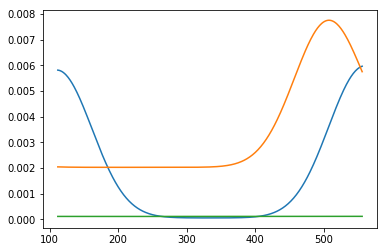

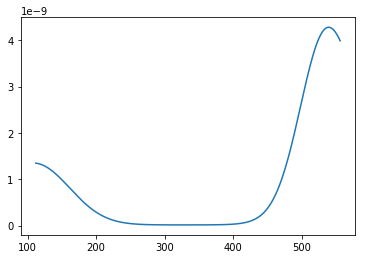

-235.61866712426212

In [60]:
## Example PLM 
doc_id = 6422
existing_qt_ids = [qt_id for qt_id in index.document(doc_id)[1] if inverted_index_positions.get(qt_id)]
qt_1 = existing_qt_ids[5] # [112, 556]
qt_2 = existing_qt_ids[25] # [507]
qt_3 = 4204 # does not exist
positional_language_model(
    doc_id, [qt_1, qt_2, qt_3], inverted_index_positions, 
    gaussian_kernel, mu = 50, print_diagram = True)
# 3.747485365662843e-05 for [qt_1, qt_2]
# 4.281483411901026e-09 for [qt_1, qt_2, qt_3]

In [21]:
import os
import pandas as pd

def generate_evaluation_results(retrieval_models, fpath_qrel, output_dir, print_info = False):
    
    # Generates <modelname>.run files (i.e. tfidf.run) 
    # containing the ranking result for the query and
    # documents that occur in the fpath_qrel file
    for mname, mfunc in retrieval_models.items():   
        start_time = time.time()
        run_retrieval(mname, mfunc, fpath_qrel) 
        if print_info:
            print ("retrieval for '{0}' took {1:.2f} secondes: ".format(mname, time.time() - start_time))
    print()
        
    # Applies trec eval on <modelname>.run and fpath_qrel files
    # to generate results/<modelname.txt> files.
    # The result files contain scores per query using different 
    # metrics (i.e. NDCG@10, recall@100, ...)
    for mname, mfunc in retrieval_models.items():     
        if print_info:
            print("Generating results for {0}".format(mname))
        os.system("mkdir -p {0}".format(output_dir))
        os.system("./trec_eval/trec_eval -m all_trec -q {0} {1}.run > {2}/{1}.txt".format(
            fpath_qrel, mname, output_dir))
    print()
        
            
def clean_evaluation_results(retrieval_models, output_dirs, print_info = False):

    def _delete_file_if_exists(fpath):
        try:
            os.remove(fpath)
        except OSError:
            pass

    for mname in retrieval_models.keys():
        _delete_file_if_exists("{0}.run".format(mname))
        for d in output_dirs:
            fpath = "{0}/{1}.txt".format(d, mname)
            if print_info:
                print("Deleting {0} if exists".format(fpath))
            _delete_file_if_exists(fpath)
    print()
    


In [22]:
from scipy import stats
import itertools

def build_df_results(retrieval_models, metrics, dirpath, print_info = False):
    # Build dataframe with trec results
    df_results = pd.DataFrame({})
    for mname, mfunc in retrieval_models.items():
        if print_info:
            print("Reading results for {0}".format(mname))
        df_model = pd.read_csv(
            '{0}/{1}.txt'.format(dirpath, mname), 
            delim_whitespace = True, 
            header = None, 
            names = ['metric', 'query_id', mname]
        )
        if len(df_results): # add column containing results for current model
            df_results = pd.merge(
                df_results, 
                df_model, 
                on=['metric', 'query_id'] 
#                 validate="one_to_one" <- Raises error
            )
        else: # create data frame with scores for first model: 'metric', 'query_id', 'model name'
            df_results = df_model

    # filter rows on metrics
    print("Filtering rows on: {0}".format(", ".join(metrics)))
    df_results = df_results[df_results.apply(
        lambda row: row['metric'] in metrics and not row['query_id'] == 'all', axis = 1)]
    for mname in retrieval_models.keys():
        df_results[mname] = df_results[mname].astype(np.float64) 

    print()
    return df_results

def analyze_evaluation_results(df_results, print_df = True, result_dir = None):

    retrieval_models = list(df_results.columns[2:])
    metrics = list(df_results['metric'].unique())

    def _calculate_pvalues(df_results):

        rm_pairs = []
        pvalues = []
        metric_names = []
        for m in metrics:
            for rm1, rm2 in itertools.product(retrieval_models, retrieval_models):
                if rm1 > rm2:
                    ttest_result = stats.ttest_rel(
                        df_results[df_results.metric == m][rm1], 
                        df_results[df_results.metric == m][rm2]
                    )
                    metric_names.append(m)
                    rm_pairs.append("{0}_{1}".format(rm1, rm2))
                    pvalues.append(ttest_result.pvalue)

        d = {'metric': metric_names, 'retrieval_pairs': rm_pairs, 'pvalues': pvalues}
        df_pvalues = pd.DataFrame( data = d)
        return df_pvalues

    df_means = df_results.groupby(['metric'])[retrieval_models].mean()
    df_means.reset_index(inplace=True)
    df_pvalues = _calculate_pvalues(df_results)
    df_pvalues.sort_values(['retrieval_pairs', 'metric']).reset_index(inplace=True)
    
    if result_dir:
        df_results.to_csv("{0}/results.csv".format(result_dir), index = False)
        df_means.to_csv("{0}/means.csv".format(result_dir), index = False)
        df_pvalues.to_csv("{0}/pvalues.csv".format(result_dir), index = False)
    
    if print_df:
        print()
        print('means: ')
        display(df_means)
        print('pvalues: ')
        display(df_pvalues)
        print('ndcg: ')
        display(df_results[df_results['metric'] == 'ndcg_cut_10'].head(20))
    
    return df_results, df_means, df_pvalues


/home/maartje/anaconda3/envs/information_retrieval_1/lib/python3.5/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


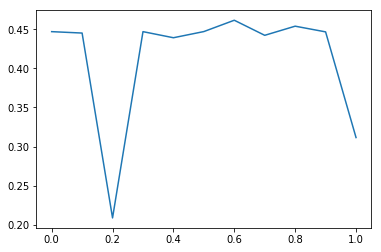

In [25]:
import subprocess
import matplotlib.pyplot as plt
%matplotlib inline  

def plot_ndcg(lm_name, lm_fn, lambda_values):
    
    # NDCG@10 versus Hyperparameters
    retrieval_models = {}
    for l in lambda_values:
        rm_name = "{0}_ndcg_{1}".format(lm_name, l)
        rm_fn = lambda x,y,l=l : lm_fn(x, y, lambda_ = l)
        retrieval_models[rm_name] = rm_fn

    clean_evaluation_results(retrieval_models, output_dirs=["ndcg"])
    generate_evaluation_results(retrieval_models, './ap_88_89/qrel_validation', "ndcg")

    ndcg10_values = []
    for mname in retrieval_models.keys():
        grep_result = subprocess.run(['grep', '-E', '^ndcg_cut_10(\s)*all', 'ndcg/{0}.txt'.format(mname)], stdout=subprocess.PIPE)
        ndcg10_all = float(grep_result.stdout.split()[2])
        ndcg10_values.append(ndcg10_all)

    plt.plot(lambda_values, ndcg10_values)
    plt.show()

plot_ndcg('jm', jelinek_mercer, [ l/10. for l in range(0, 11)])

In [54]:
# use these for tuning hyper parameters
fpath_qrel_val = './ap_88_89/qrel_validation'
output_dir_val = "results_val"

retrieval_models = { 
    
    # Jelinek-Mercer
    'jm_0.1' : lambda x,y : jelinek_mercer(x, y, lambda_ = 0.1),
    'jm_0.5' : lambda x,y : jelinek_mercer(x, y, lambda_ = 0.5),
    'jm_0.9' : lambda x,y : jelinek_mercer(x, y, lambda_ = 0.9),

    # Dirichlet prior
    'dir_500'  : lambda x,y : dirichlet_prior(x, y, mu = 500),
    'dir_1000' : lambda x,y : dirichlet_prior(x, y, mu = 1000),
    'dir_1500' : lambda x,y : dirichlet_prior(x, y, mu = 1500),
    
    # absolute discounting
    'abs_0.1' : lambda x,y : absolute_discounting(x, y, delta = 0.1),
    'abs_0.5' : lambda x,y : absolute_discounting(x, y, delta = 0.5),
    'abs_0.9' : lambda x,y : absolute_discounting(x, y, delta = 0.9)
}

metrics = [ 'map_cut_1000', 'ndcg_cut_10', 'P_5', 'recall_1000' ]

clean_evaluation_results(retrieval_models, output_dirs=[output_dir_test])

generate_evaluation_results(retrieval_models, fpath_qrel_test, output_dir_test)  

result_dir = "results_eval_lm"
df_results = build_df_results(retrieval_models, metrics, output_dir_test)
df_results, df_means, df_pvalues = analyze_evaluation_results(df_results, print_df=True, result_dir = result_dir)


Deleting results_test/jm_0.5.txt if exists
Deleting results_test/dir_1000.txt if exists
Deleting results_test/jm_0.1.txt if exists
Deleting results_test/jm_0.9.txt if exists
Deleting results_test/abs_0.9.txt if exists
Deleting results_test/dir_1500.txt if exists
Deleting results_test/dir_500.txt if exists
Deleting results_test/abs_0.1.txt if exists
Deleting results_test/abs_0.5.txt if exists

Retrieving using jm_0.5
retrieval for 'jm_0.5' took 2.62 secondes: 
Retrieving using dir_1000
retrieval for 'dir_1000' took 2.35 secondes: 
Retrieving using jm_0.1
retrieval for 'jm_0.1' took 2.59 secondes: 
Retrieving using jm_0.9
retrieval for 'jm_0.9' took 2.59 secondes: 
Retrieving using abs_0.9
retrieval for 'abs_0.9' took 6.44 secondes: 
Retrieving using dir_1500
retrieval for 'dir_1500' took 2.35 secondes: 
Retrieving using dir_500
retrieval for 'dir_500' took 2.35 secondes: 
Retrieving using abs_0.1
retrieval for 'abs_0.1' took 6.74 secondes: 
Retrieving using abs_0.5
retrieval for 'abs_0.

,metric,jm_0.5,dir_1000,jm_0.1,jm_0.9,abs_0.9,dir_1500,dir_500,abs_0.1,abs_0.5
0,P_5,0.436975,0.448739,0.381513,0.475630,0.465546,0.452101,0.457143,0.478992,0.472269
1,map_cut_1000,0.395798,0.393496,0.379089,0.406345,0.399619,0.394598,0.390915,0.402112,0.402178
2,ndcg_cut_10,0.440366,0.446853,0.394701,0.467395,0.459223,0.449911,0.442294,0.452233,0.461867
3,recall_1000,0.982648,0.982648,0.982648,0.982648,0.982648,0.982648,0.982648,0.982648,0.982648


pvalues: 


,metric,pvalues,retrieval_pairs
0,P_5,0.401676,jm_0.5_dir_1000
1,P_5,0.000561,jm_0.5_jm_0.1
2,P_5,0.119581,jm_0.5_abs_0.9
3,P_5,0.307051,jm_0.5_dir_1500
4,P_5,0.083253,jm_0.5_dir_500
5,P_5,0.064346,jm_0.5_abs_0.1
6,P_5,0.079005,jm_0.5_abs_0.5
7,P_5,0.375227,dir_1000_abs_0.9
8,P_5,0.222135,dir_1000_abs_0.1
9,P_5,0.281951,dir_1000_abs_0.5


ndcg: 


,metric,query_id,jm_0.5,dir_1000,jm_0.1,jm_0.9,abs_0.9,dir_1500,dir_500,abs_0.1,abs_0.5
56,ndcg_cut_10,100,0.7001,0.6727,0.5331,0.7105,0.8263,0.6727,0.7001,0.7163,0.7799
147,ndcg_cut_10,101,0.5837,0.4548,0.6060,0.6033,0.4506,0.4548,0.4787,0.5033,0.4734
238,ndcg_cut_10,102,0.5022,0.5587,0.4915,0.4983,0.5072,0.5619,0.5022,0.3594,0.4761
329,ndcg_cut_10,104,0.4473,0.2980,0.7382,0.2934,0.2122,0.3878,0.3382,0.2903,0.2173
420,ndcg_cut_10,105,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
511,ndcg_cut_10,106,0.5617,0.6497,0.4883,0.5252,0.4115,0.7543,0.4558,0.3536,0.3024
602,ndcg_cut_10,107,0.4955,0.5965,0.2182,0.7846,0.7818,0.5919,0.6122,0.7273,0.7968
693,ndcg_cut_10,108,0.2083,0.1834,0.1447,0.2240,0.2048,0.1732,0.2173,0.2240,0.2489
784,ndcg_cut_10,109,0.4681,0.6169,0.4681,0.4681,0.5694,0.6169,0.6139,0.5443,0.5443
875,ndcg_cut_10,110,0.3700,0.8263,0.5463,0.4131,0.5549,0.8205,0.4787,0.4964,0.5112


In [ ]:
# use these for tuning hyper parameters
fpath_qrel_val = './ap_88_89/qrel_validation'
output_dir_val = "results_val"

# build dict with retrieval functions
# for all combinations of kernel functions
# and mu hyper parameters in { 500, 1000, 1500 }
retrieval_models = { }

kernels = {
    "gaussian" : gaussian_kernel, 
    "circle"   : circle_kernel, 
    "triangle" : triangle_kernel, 
    "passage"  : passage_kernel, 
    "cosine"   : cosine_kernel
}

def add_plm_models(kname, fn_k, mu_values):
    zi_cache = {} # can be shared by models with the same kernel (but different mu)
    for mu in mu_values: # loop over mu values
        retrieval_models["plm_{}_{}".format(kname, mu)] = lambda x,y: positional_language_model(
            x, y, inverted_index_positions, fn_k, zi_cache)

for kname, fn_k in kernels.items(): # loop over kernel functions
    add_plm_models(kname, fn_k, [ 500, 1000, 1500 ])
    

metrics = [ 'map_cut_1000', 'ndcg_cut_10', 'P_5', 'recall_1000' ]

clean_evaluation_results(retrieval_models, output_dirs=[output_dir_test])

generate_evaluation_results(retrieval_models, fpath_qrel_test, output_dir_test)  

result_dir = "results_eval_plm"
df_results = build_df_results(retrieval_models, metrics, output_dir_test)
df_results, df_means, df_pvalues = analyze_evaluation_results(df_results, print_df=True, result_dir = result_dir)

In [50]:
# use these for camparison of metrics
fpath_qrel_test = './ap_88_89/qrel_test'
output_dir_test = "results_test"

cache_zi_gaussian_50 = {}
retrieval_models = { 
    'tfidf' : tfidf, 
    'BM25': BM25,
    'jm_0.9' : lambda x,y : jelinek_mercer(x, y, 0.9),
    'dir_1500' : lambda x,y : dirichlet_prior(x, y, 1500), 
    'abs_0.1' : lambda x,y : absolute_discounting(x, y, 0.5),
#     'plm_gaussian_x' : lambda x,y :positional_language_model(x,y, inverted_index_positions, gaussian_kernel, cache_zi_gaussian_50)
}

metrics = [ 'map_cut_1000', 'ndcg_cut_10', 'P_5', 'recall_1000' ]

clean_evaluation_results(retrieval_models, output_dirs=[output_dir_test])

generate_evaluation_results(retrieval_models, fpath_qrel_test, output_dir_test)  

result_dir = "results_eval_test"
df_results = build_df_results(retrieval_models, metrics, output_dir_test)
df_results, df_means, df_pvalues = analyze_evaluation_results(df_results, print_df=True, result_dir = result_dir)


Deleting results_test/dir_1500.txt if exists
Deleting results_test/BM25.txt if exists
Deleting results_test/abs_0.1.txt if exists
Deleting results_test/jm_0.9.txt if exists
Deleting results_test/tfidf.txt if exists

Retrieving using dir_1500
retrieval for 'dir_1500' took 2.57 secondes: 
Retrieving using BM25
retrieval for 'BM25' took 2.14 secondes: 
Retrieving using abs_0.1
retrieval for 'abs_0.1' took 6.40 secondes: 
Retrieving using jm_0.9
retrieval for 'jm_0.9' took 2.48 secondes: 
Retrieving using tfidf
retrieval for 'tfidf' took 1.12 secondes: 

Generating results for dir_1500
Generating results for BM25
Generating results for abs_0.1
Generating results for jm_0.9
Generating results for tfidf

Reading results for dir_1500
Reading results for BM25
Reading results for abs_0.1
Reading results for jm_0.9
Reading results for tfidf
Filtering rows on: map_cut_1000, ndcg_cut_10, P_5, recall_1000


means: 


,metric,dir_1500,BM25,abs_0.1,jm_0.9,tfidf
0,P_5,0.452101,0.467227,0.470588,0.475630,0.504202
1,map_cut_1000,0.394598,0.407674,0.400838,0.406353,0.409892
2,ndcg_cut_10,0.449911,0.479071,0.459361,0.467395,0.493584
3,recall_1000,0.982648,0.982648,0.982648,0.982648,0.982648


pvalues: 


,metric,pvalues,retrieval_pairs
0,P_5,0.363013,dir_1500_BM25
1,P_5,0.410638,dir_1500_abs_0.1
2,P_5,0.848330,abs_0.1_BM25
3,P_5,0.210033,jm_0.9_dir_1500
4,P_5,0.555138,jm_0.9_BM25
5,P_5,0.682081,jm_0.9_abs_0.1
6,P_5,0.011042,tfidf_dir_1500
7,P_5,0.047751,tfidf_BM25
8,P_5,0.145398,tfidf_abs_0.1
9,P_5,0.167500,tfidf_jm_0.9


ndcg: 


,metric,query_id,dir_1500,BM25,abs_0.1,jm_0.9,tfidf
56,ndcg_cut_10,100,0.6727,0.7289,0.7799,0.7105,0.7506
147,ndcg_cut_10,101,0.4548,0.5303,0.4734,0.6033,0.1732
238,ndcg_cut_10,102,0.5619,0.4925,0.4761,0.4983,0.4698
329,ndcg_cut_10,104,0.3878,0.4658,0.2173,0.2934,0.2992
420,ndcg_cut_10,105,0.0000,0.0000,0.0000,0.0000,0.0000
511,ndcg_cut_10,106,0.7543,0.6118,0.3024,0.5252,0.5829
602,ndcg_cut_10,107,0.5919,0.8007,0.7968,0.7846,0.7034
693,ndcg_cut_10,108,0.1732,0.1834,0.2489,0.2240,0.2497
784,ndcg_cut_10,109,0.6169,0.4681,0.5443,0.4681,0.4570
875,ndcg_cut_10,110,0.8205,0.5420,0.5112,0.4131,1.0000


### Task 2: Latent Semantic Models (LSMs) [15 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

In [ ]:
import logging, gensim, bz2
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from gensim.corpora.mmcorpus import MmCorpus
from gensim.corpora.lowcorpus import LowCorpus
from gensim.corpora.dictionary import Dictionary

dictionary_obj = gensim.corpora.dictionary.Dictionary()
dictionary_obj.token2id = token2id

# example
dictionary_obj.doc2idx(document=['human', 'computer', 'interface'], unknown_word_index=-1)
print(dictionary_obj)


#TODO: CREATE CORPUS
#MmCorpus.serialize('test.mm', test_corpus)
#mm = MmCorpus('test.mm') # `mm` document stream now has random access
#print(mm[42]) # retrieve document no. 42, etc.

In [ ]:
# MODELS (both need corpus)
from gensim.models.lsimodel import LsiModel
from gensim.models.ldamodel import LdaModel

# extract 400 LSI topics; use the default one-pass algorithm
#lsi = LsiModel(corpus=test_corpus, id2word=id2token, num_topics=10)
#print(lsi)

# print the most contributing words (both positively and negatively) for each of the first ten topics
#lsi.print_topics(10)

#lda = LdaModel(corpus, num_topics=10)  # train model
#print(lda[doc_bow]) # get topic probability distribution for a document
#lda.update(corpus2) # update the LDA model with additional documents
#print(lda[doc_bow])

In [ ]:
# CLASS FROM PYNDRI WITH MINOR CHANGE
class SelfMadeIndriSentences(gensim.interfaces.CorpusABC):
    """Integrates an Index with Gensim's word2vec implementation."""

    def __init__(self, index, dictionary, max_documents=None):
        assert isinstance(index, pyndri.Index)
        self.index = index
        self.dictionary = dictionary
        self.max_documents = max_documents

    def _maximum_document(self):
        if self.max_documents is None:
            return self.index.maximum_document()
        else:
            return min(
                self.max_documents + self.index.document_base(),
                self.index.maximum_document())

    def __iter__(self):
        for int_doc_id in range(self.index.document_base(),
                                self._maximum_document()):
            ext_doc_id, tokens = self.index.document(int_doc_id)

            # CHANGED:
            yield [token_id
                for token_id in tokens
                if token_id > 0 and token_id in self.dictionary]

    def __len__(self):
        return self._maximum_document() - self.index.document_base()

In [ ]:
'''
Should we apply a tfidf transformation to the corpus before
applying LSI / LDA? Is it something we can decide freely on?
Yes. It's up to you.
------------------------------------------------------------
ValueError: too many values to unpack (expected 2)
That's expected. You need to implement a similar class, 
but one that returns the right representation of an item. 
IndriSentences returns strings, but you need a sparse vector of token ids.
'''
from pyndri import compat

index = pyndri.Index('index/')
dictionary = pyndri.extract_dictionary(index)
sentences = SelfMadeIndriSentences(index, dictionary)
print(sentences)
print(sentences.index)
print(sentences.dictionary)
print(sentences.max_documents)
print(len(sentences))
#lsi = gensim.models.lsimodel.LsiModel(corpus=sentences, id2word=dictionary.id2token, num_topics=10)

In [ ]:
for sen in sentences:
    print(sen)
    break

In [ ]:
lsi = gensim.models.lsimodel.LsiModel(corpus=sentences,
        id2word=dictionary.id2token, num_topics=10)
print(lsi)

In [1]:
from scipy import spatial

def cosine_similarity(vec1, vec2):
    return 1 - spatial.distance.cosine(vec1, vec2)

print(cosine_similarity([0, 0, 1, 1], [0, 0, 1, 1]))
print(cosine_similarity([0, 0, 1, 1], [1, 1, 0, 0]))
print(cosine_similarity([0, 0, 1, 1], [1, 1, 1, 1]))

1.0
0.0
0.7071067811865475


### Task 3:  Word embeddings for ranking [20 points] (open-ended) ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).
   
This is an open-ended task. It is left up you to decide how you will combine word embeddings to derive query and document representations. Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt.tar.gz). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

In [38]:
import gensim
from pyndri import compat
import copy

def word2vec(epochs = 1):
    
    word2vec_init = gensim.models.Word2Vec(
        size=300,    # Embedding size
        window=5,    # One-sided window size
        sg=True,     # Skip-gram.
        min_count=5, # Minimum word frequency.
        sample=1e-3, # Sub-sample threshold.
        hs=False,    # Hierarchical softmax.
        negative=10, # Number of negative examples.
        iter=1,      # Number of iterations.
        workers=8,   # Number of workers.
    )

    with pyndri.open('./index') as index:
        dictionary = pyndri.extract_dictionary(index)
        sentences = compat.IndriSentences(index, dictionary)

        # Build vocab
        word2vec_init.build_vocab(sentences, trim_rule=None)

        model = copy.deepcopy(word2vec_init)
        model.train(sentences, total_examples = model.corpus_count, epochs = epochs)

        return model
    
# word_vectors = word2vec(epochs = 5)

In [39]:
fname = 'word_vectors'

# Use to save model
# word_vectors.save(fname) 

# Use to load model
word_vectors = gensim.models.Word2Vec.load(fname)

In [41]:
# Give a word vector
# word_vectors.wv['computer']

In [84]:
def avg_weighted_vector(query):
    query_tokens = [token for token in index.tokenize(query) if len(token) > 0]
    query2vectors = word_vectors.wv[query_tokens]
    
    weighted_vectors = []
    
    for query_token, query_id_token in zip(query_tokens, [token2id.get(query_token,0) for query_token in query_tokens]):
        corpus_term_freq = total_corpus_term_freqs[query_id_token]
        word_vec = word_vectors.wv[query_token]
        
        weighted_vectors.append(word_vec / corpus_term_freq)
        
    return np.mean(weighted_vectors, axis=0)

In [146]:
query_vector = avg_weighted_vector("bitch")

In [147]:
word_vectors.wv.similar_by_vector(query_vector)

[('bitch', 1.0000001192092896),
 ('jokester', 0.6488711833953857),
 ('circuslike', 0.6444293260574341),
 ('colich', 0.6300046443939209),
 ('mondellos', 0.6262781023979187),
 ('nunally', 0.6249598264694214),
 ('smirking', 0.6212821006774902),
 ('aronne', 0.6179535984992981),
 ('ranted', 0.616774320602417),
 ('villane', 0.6164078712463379)]

### Task 4: Learning to rank (LTR) [15 points] (open-ended) ###

In this task you will get an introduction into learning to rank for information retrieval.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1, Task 2 and Task 3 as features. Think about other features you can use (e.g. query/document length). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

You are adviced to start some pointwise learning to rank algorithm e.g. logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set. More advanced learning to rank algorithms will be appreciated when grading.

### Task 4: Write a report [15 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.
